# Code to handle Data

In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

import torchinfo

import numpy as np
import time

import skimage
from tqdm import tqdm


# Utilities
import os
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# Confusion Matrix
import seaborn as sn
import pandas as pd

import sys
sys.path.insert(1, 'util')
import vcpi_util

In [55]:
print(torch.__version__)

2.2.1+cu121


In [56]:
def train(model, train_loader, val_loader, epochs, loss_fn, optimizer, scheduler, early_stopper, save_prefix = 'model'):

    history = {}

    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, _) in tqdm(enumerate(train_loader, 0)):
            
            inputs = inputs.to(device)
    
            outputs = model(inputs)
    
            loss = loss_fn(outputs, inputs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().detach().numpy()
     
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i,_ in val_loader:
                i = i.to(device)
                o = model(i)
                
                #with torch.no_grad():
                val_loss += loss_fn(o, i).cpu().detach().numpy()


        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Val Loss: {val_loss:0.6f}; Elapsed time: {(stop_time - start_time):0.4f}')

        history['val_loss'].append(val_loss)
        history['loss'].append(epoch_loss)
 
        ###### Saving ######
        if val_loss < best_val_loss:
           
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'history': history,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
                },
                f'{save_prefix}_best.pt')
            best_val_loss = val_loss

        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)



class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_val_loss = float('inf')

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False
    
from matplotlib import colors

def plot_scatter(x,y,targets):
    cmap = colors.ListedColormap(['black', 'darkred', 'darkblue', 
                                  'darkgreen', 'yellow', 'brown', 
                                  'purple', 'lightgreen', 'red', 'lightblue'])
    bounds=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,8.5,9.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10,10))
    plt.scatter(x, y, c = targets, cmap=cmap, s = 1, norm=norm)
    plt.colorbar()

    plt.show()


def show_preds(set1, set2, count):
  
  columns = 4
  rows = int(count*2 / columns) + 1  
  plt.figure(figsize=(count, 2 * rows))
  
  for n in range(count):
      ax = plt.subplot(rows, columns, n*2+1)
      plt.title("original")
      plt.imshow(np.transpose(set1[n].numpy(), (1,2,0)), cmap=plt.cm.gray)
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*2+2)
      plt.title("reconstruction")
      plt.imshow(np.transpose(set2[n].cpu().detach().numpy(), (1,2,0)), cmap=plt.cm.gray)
      plt.axis('off')        

In [57]:
HEIGHT = 32
WIDTH = 32
NUM_CHANNELS = 3
BATCH_SIZE = 32
LATENT_SPACE_DIM = 2

MODEL_PATH = 'model_result'

train_online = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [58]:
from importlib import reload
reload(vcpi_util)

<module 'vcpi_util' from '/mnt/c/Users/User/Desktop/VCPI-TP2/util/vcpi_util.py'>

In [59]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data
# Define transformations
transform = transforms.Compose([
    transforms.Resize((32,32)), # The images differ in size so we resized them to 32x32
    transforms.ToTensor()
])

# Create datasets from directories
train_dataset = datasets.ImageFolder(root='./train_images', transform=transform)
test_dataset = datasets.ImageFolder(root='./test_images', transform=transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_set, val_set = random_split(train_dataset, [train_size, val_size])
# Create data loaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Example: Print the sizes of the datasets
print(f'Training set size: {len(train_set)}')
print(f'Validation set size: {len(val_set)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 31367
Validation set size: 7842
Test set size: 12630


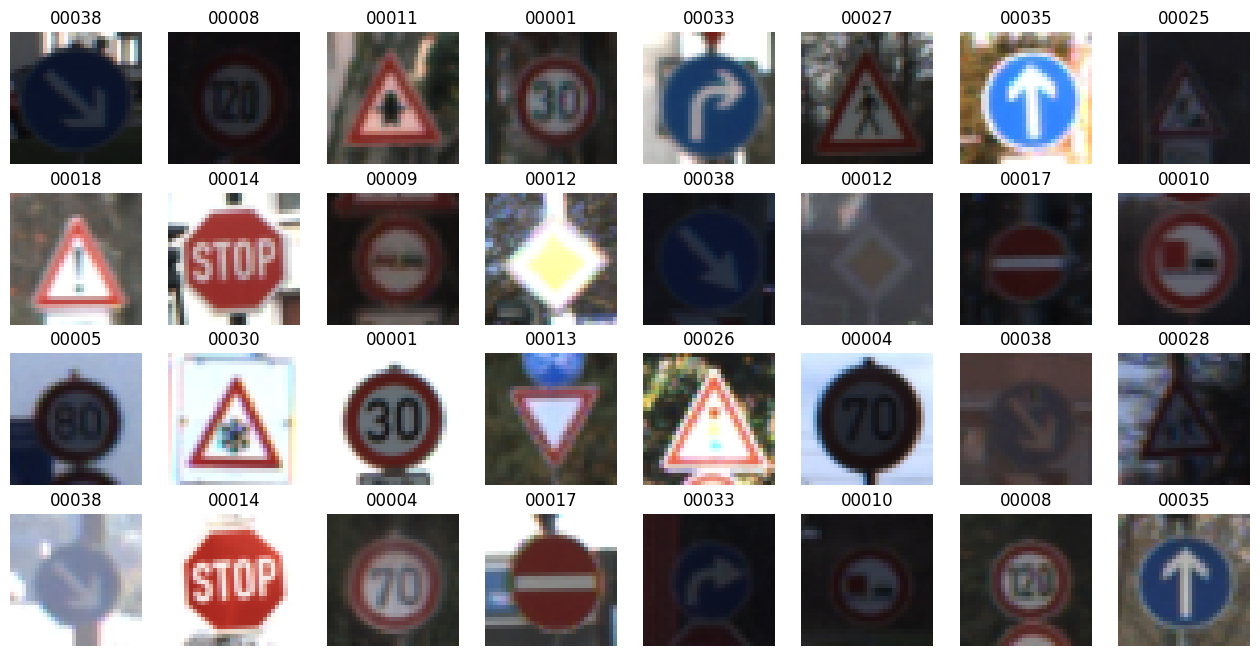

<Figure size 640x480 with 0 Axes>

In [60]:
images, targets = next(iter(train_loader))

vcpi_util.show_images(4,8, images, targets, train_dataset.classes) 

# Observations on initial data



In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

class AutoEncoder(nn.Module):
    def __init__(self, latent_space_dim):
        super(AutoEncoder, self).__init__()

        # encoder layers
        self.econv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.erelu1 = nn.ReLU()
        self.ebn1 = nn.BatchNorm2d(32)

        self.econv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.erelu2 = nn.ReLU()
        self.ebn2 = nn.BatchNorm2d(64)

        self.efc1 = nn.Linear(64 * 8 * 8, latent_space_dim)

        # decoder layers
        self.dfc1 = nn.Linear(latent_space_dim, 64 * 8 * 8)
        
        self.dconvT1 = nn.ConvTranspose2d(64, 32, 3, 2, padding=1, output_padding=1)
        self.drelu1 = nn.ReLU()
        self.dbn1 = nn.BatchNorm2d(32)

        self.dconvT2 = nn.ConvTranspose2d(32, 3, 3, 2, padding=1, output_padding=1)
        self.dsig = nn.Sigmoid()

    def encoder(self, x):
        x = self.econv1(x)
        x = self.ebn1(x)
        x = self.erelu1(x)

        x = self.econv2(x)
        x = self.ebn2(x)
        x = self.erelu2(x)

        x = torch.flatten(x, 1)
        x = self.efc1(x)

        return x
        
    def decoder(self, x):
        x = self.dfc1(x)
        x = x.view(-1, 64, 8, 8)
        x = self.dconvT1(x)
        x = self.dbn1(x)
        x = self.drelu1(x)

        x = self.dconvT2(x)
        x = self.dsig(x)

        return x

    def forward(self, x):
        encoded = self.encoder(x)
        output = self.decoder(encoded)
        return output


In [63]:
AE = AutoEncoder(LATENT_SPACE_DIM)
AE.to(device)
print(AE)

torchinfo.summary(AE, input_size=(BATCH_SIZE, NUM_CHANNELS, HEIGHT, WIDTH))

AutoEncoder(
  (econv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (erelu1): ReLU()
  (ebn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (econv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (erelu2): ReLU()
  (ebn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (efc1): Linear(in_features=4096, out_features=2, bias=True)
  (dfc1): Linear(in_features=2, out_features=4096, bias=True)
  (dconvT1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (drelu1): ReLU()
  (dbn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconvT2): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dsig): Sigmoid()
)


Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [32, 3, 32, 32]           --
├─Conv2d: 1-1                            [32, 32, 16, 16]          896
├─BatchNorm2d: 1-2                       [32, 32, 16, 16]          64
├─ReLU: 1-3                              [32, 32, 16, 16]          --
├─Conv2d: 1-4                            [32, 64, 8, 8]            18,496
├─BatchNorm2d: 1-5                       [32, 64, 8, 8]            128
├─ReLU: 1-6                              [32, 64, 8, 8]            --
├─Linear: 1-7                            [32, 2]                   8,194
├─Linear: 1-8                            [32, 4096]                12,288
├─ConvTranspose2d: 1-9                   [32, 32, 16, 16]          18,464
├─BatchNorm2d: 1-10                      [32, 32, 16, 16]          64
├─ReLU: 1-11                             [32, 32, 16, 16]          --
├─ConvTranspose2d: 1-12                  [32, 3, 32, 32]           8

In [64]:
# latent_dims = [2,4,8,16]

# loss_fn = torch.nn.loss_fn = torch.nn.MSELoss()

# for ld in latent_dims:
    
#     AE = AutoEncoder(ld)
#     AE.to(device)

#     opt = torch.optim.Adam(AE.parameters(), lr=1e-3)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor = 0.1, patience=3)
#     early_stop = Early_Stopping(9)
    
#     history=train(AE, train_loader, val_loader, 100, loss_fn, opt,  scheduler, early_stop, f'{MODEL_PATH}/autoencoder_{ld}' )

339it [02:30,  2.26it/s]


KeyboardInterrupt: 

In [ ]:
LATENT_SPACE_DIM = 2
reload = torch.load(f'autoencoder_models/autoencoder_{LATENT_SPACE_DIM}_best.pt')
print(reload['epoch'])
AE = AutoEncoder(LATENT_SPACE_DIM)
AE.to(device)
AE.load_state_dict(reload['model'])